# Exploratory Analysis


In [1]:
import os

os.chdir("..")
os.getcwd()

'c:\\Users\\luisa\\Documents\\Pasta pessoal\\Insper\\Machine Learning\\Projetos\\Stock-Price-Prediction'

In [8]:
from pathlib import Path

import mplfinance as mpf
import pandas as pd
from matplotlib import pyplot as plt
import pickle

## Fetch datasets

In [ ]:
BASE_URL = "https://data.binance.vision/data/futures/cm/daily/bookTicker/"

datasets= {
    "ADA": [
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "AXS": [
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "BTC": [
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "DOGE": [
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "NEAR": [
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-20.zip",
    ],
}

In [ ]:
from scripts.pull_datasets import execute as pull_datasets

pull_datasets(datasets)

## Run Preprocessing script

In [ ]:
from scripts.preprocess import execute as preprocess

for ticker in datasets.keys():
    preprocess(ticker)

## Build Open-High-Low-Close charts of `mid_price` for each day

In [5]:
basedir = Path.cwd()
datadir = basedir / "data"
resultsdir = basedir / "assets" / "image"

def to_OHLC(df: pd.DataFrame, pattern: str):
    return df.resample(pattern).agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last"
    })


In [6]:
resultsdir.mkdir(parents=True, exist_ok=True)

for datafile in (datadir / "tickers").glob("**/*-raw.parquet"):
    name = datafile.stem[:-4]
    df = pd.read_parquet(datafile)
    data = to_OHLC(df["mid_price"], "1h")
    data["Volume"] = df["Trades"].resample("1h").agg("sum")
    title = name.replace("_", " ").replace("-", " - ")

    mpf.plot(
        data=data,
        type="candle",
        style="binance",
        volume=True,
        title=title,
        savefig=resultsdir / (name + "-ohlc.svg"),
    )


In [3]:
validation_datafiles = (datadir / "tickers").glob("**/*-day_5-raw.parquet")
prediction_datafiles = (datadir / "predictions").glob("MLP-*.parquet")

for y_true, y_hat in zip(validation_datafiles, prediction_datafiles):
    title = y_hat.stem.replace("-", " - ")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title)
    ax1.set_title("Actual")
    ax2.set_title("Predicted")

    data1 = to_OHLC(pd.read_parquet(y_true)["mid_price"], "1h")
    data2 = to_OHLC(pd.read_parquet(y_hat), "1h")
    combined_ymin = min(data1.min().min(), data2.min().min())
    combined_ymax = max(data1.max().max(), data2.max().max())

    ax1.set_ylim(combined_ymin, combined_ymax)
    ax2.set_ylim(combined_ymin, combined_ymax)

    mpf.plot(data1, type="candle", style="binance", ax=ax1)
    mpf.plot(data2, type="candle", style="binance", ax=ax2)
    plt.savefig(resultsdir / y_hat.with_suffix(".svg").name)


NameError: name 'datadir' is not defined

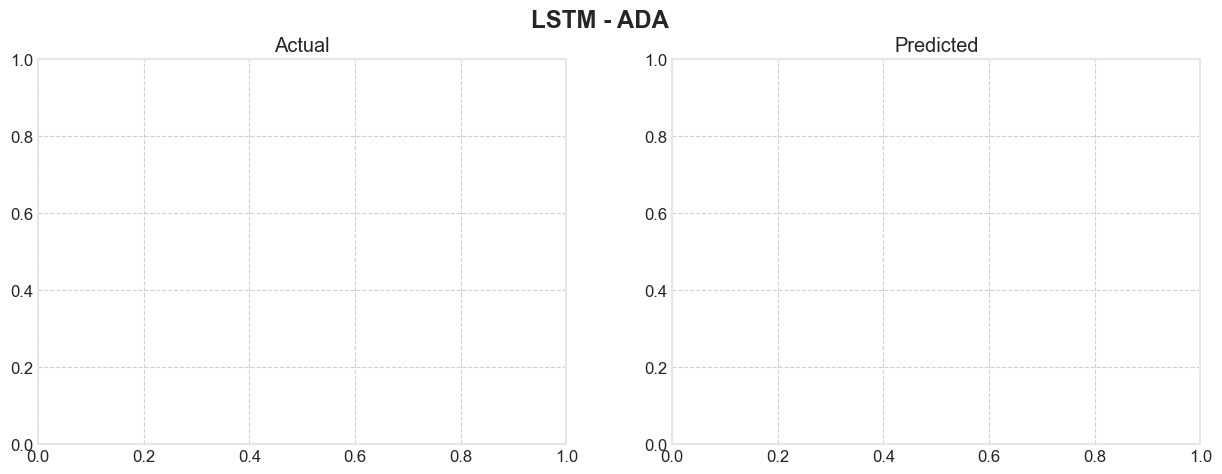

In [9]:
validation_datafiles = (datadir / "tickers").glob("**/*-day_5-raw.parquet")
prediction_datafiles = (datadir / "predictions").glob("LSTM-*.parquet")

for y_true, y_hat in zip(validation_datafiles, prediction_datafiles):

    title = y_hat.stem.replace("-", " - ")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title)
    ax1.set_title("Actual")
    ax2.set_title("Predicted")

    data1 = to_OHLC(pd.read_parquet(y_true)["mid_price"], "1h")
    data2 = to_OHLC(pd.read_parquet(y_hat), "1h")
    break
    combined_ymin = min(data1.min().min(), data2.min().min())
    combined_ymax = max(data1.max().max(), data2.max().max())

    ax1.set_ylim(combined_ymin, combined_ymax)
    ax2.set_ylim(combined_ymin, combined_ymax)

    mpf.plot(data1, type="candle", style="binance", ax=ax1)
    mpf.plot(data2, type="candle", style="binance", ax=ax2)
    plt.savefig(resultsdir / y_hat.with_suffix(".svg").name)


In [10]:
data2

,Open,High,Low,Close
event_time,,,,
2024-05-20 00:00:00,-0.579004,-0.479976,-0.627843,-0.602848
2024-05-20 01:00:00,-0.606099,-0.535386,-0.632110,-0.623987
2024-05-20 02:00:00,-0.624977,-0.294458,-0.625766,-0.419874
2024-05-20 03:00:00,-0.437277,-0.114876,-0.461835,-0.270058
2024-05-20 04:00:00,-0.291569,0.350720,-0.305325,0.259184
2024-05-20 05:00:00,0.279809,0.442479,0.165910,0.157201
2024-05-20 06:00:00,0.170648,0.402911,-0.632115,-0.632028
2024-05-20 07:00:00,-0.632066,-0.565872,-0.632101,-0.584861
2024-05-20 08:00:00,-0.584354,-0.416580,-0.600367,-0.475398


In [14]:
scaler_ADA = pickle.load(open(datadir / "scalers" / "ADA-5.pkl", "rb"))
scaler_BTC = pickle.load(open(datadir / "scalers" / "BTC-5.pkl", "rb"))
scaler_DOGE = pickle.load(open(datadir / "scalers" / "DOGE-5.pkl", "rb"))
scaler_NEAR = pickle.load(open(datadir / "scalers" / "NEAR-5.pkl", "rb"))
scaler_AXS = pickle.load(open(datadir / "scalers" / "AXS-5.pkl", "rb"))

C:\Users\luisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
# desnormalizar data2
data2 = scaler_ADA.inverse_transform(data2)
data2

ValueError: operands could not be broadcast together with shapes (24,4) (21,) (24,4) 